# Create a spectorgram from a nanopore read
* down loads sample fast5 files from Chiron github repo if needed
* play around with value of nfft

In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

/Users/andrewdavidson/workSpace/pythonEnv/DeepBio/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import os
import requests

file_name = "read1.fast5" # read2.fast5 read3.fast4 read5.fast5 
fast5_path = "data/" + file_name
# note the download url is not the same as the url you use when you view the file in github
# notice 'raw' and 'blob' are different
#read_fast5_url = "https://github.com/haotianteng/Chiron/blob/master/chiron/example_data/" + file_name
read_fast5_url = "https://raw.github.com/haotianteng/Chiron/master/chiron/example_data/" + file_name

if not os.path.exists(fast5_path):
    directory = os.path.dirname(fast5_path )
    if not os.path.exists(directory):
        os.makedirs(directory)
    r = requests.get(read_fast5_url)
    r.raise_for_status()
    with open(fast5_path, "wb") as f:
        for chunk in r.iter_content(32768):
            f.write(chunk)    

In [3]:
with h5py.File(fast5_path, 'r') as fast5_data :
    # Get samping rate
    fast5_info = fast5_data['UniqueGlobalKey/channel_id'].attrs
    sampling_rate = fast5_info['sampling_rate'].astype('int_')     
#     raw_dat = fast5_data['/Raw/Reads/'].values()[0]
    raw_data_set = fast5_data['/Raw/Reads/Read_104/Signal'] # .values()[0]
    #raw_data = raw_dat['Signal'].values()
    raw_data = raw_data_set[:]


n = len(raw_data)
print("sampling_rate:", sampling_rate)
print("n:", n)
print("time in sec:", n / sampling_rate)

sampling_rate: 4000
n: 62461
time in sec: 15.61525


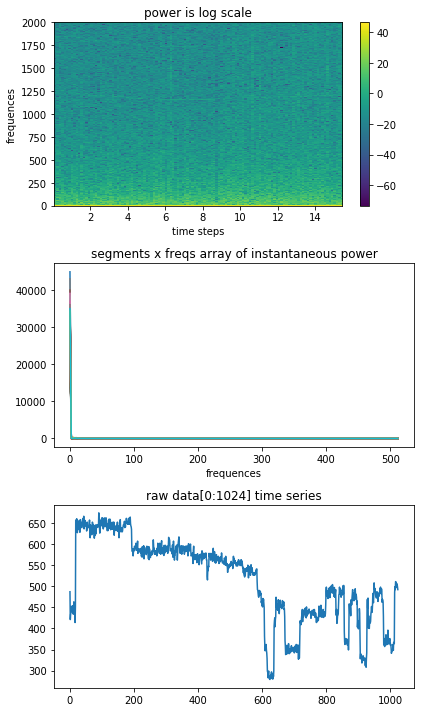

num win 120.0
len(freqs): 513 
freqs[0:10]
 [ 0.       3.90625  7.8125  11.71875 15.625   19.53125 23.4375  27.34375
 31.25    35.15625] 
freqs[-10:]
 [1964.84375 1968.75    1972.65625 1976.5625  1980.46875 1984.375
 1988.28125 1992.1875  1996.09375 2000.     ]
len(bins): 120 
bins[0:10]
 [0.128 0.256 0.384 0.512 0.64  0.768 0.896 1.024 1.152 1.28 ] 
bins[-10:]
 [14.208 14.336 14.464 14.592 14.72  14.848 14.976 15.104 15.232 15.36 ]


In [4]:
# pxx is the segments x freqs array of instantaneous power,
# freqs is the frequency vector,
# bins are the centers of the time bins in which the power is 
#      computed,
# im is the matplotlib.image.AxesImage instance

fig = plt.figure(figsize=(6,10))
grid = 311 # nrow, ncol, place in grid
plt.subplot(grid) 
    
nfft = 1024
noverlap = int( nfft / 2 )
pxx, freqs, bins, im = plt.specgram(raw_data, NFFT=nfft, Fs=sampling_rate, 
                                    noverlap=noverlap, 
#                                         scale='linear'
                                   )

plt.xlabel("time steps")
plt.ylabel("frequences")
plt.title("power is log scale")
fig.colorbar(im)


grid += 1
plt.subplot(grid) # nrow, ncol, place in grid
plt.plot(pxx)
plt.xlabel("frequences")
plt.title("segments x freqs array of instantaneous power")

grid +=1 
plt.subplot(grid) # nrow, ncol, place in grid
plt.plot(raw_data[0:nfft])
plt.title("raw data[0:" + str(nfft) + "] time series")
    
plt.tight_layout() # adjust so that labels do not over lap

plt.show()

print("num win", np.floor((n - nfft)/noverlap) + 1)
print("len(freqs):", len(freqs), "\nfreqs[0:10]\n", freqs[0:10],"\nfreqs[-10:]\n", freqs[-10:] )
print("len(bins):",  len(bins),  "\nbins[0:10]\n",  bins[0:10], "\nbins[-10:]\n",  bins[-10:])